## Libraries

In [16]:
import sys
import os
import numpy as np
import pandas as pd
import glob
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## ModelDataLoader

In [2]:
class ModelDataLoader():
    '''Loads and provides access to model input data and related information'''
    def __init__(self, version='005'):
        # Use the specific path for the data
        self.data_path = f'/content/drive/MyDrive/model_input_{version}'
        self.df = self.get_df_from_parquet()
        self.feature_names = [
            'spectral_centroids_mean',
            'spectral_centroids_delta_mean',
            'spectral_centroids_accelerate_mean',
            'spectral_bandwidth_mean',
            'spectral_rolloff_mean',
            'zero_crossing_rate_mean',
            'rms_mean',
            'chroma_stft_mean',
            'mfccs_mean',
            'onset',
            'tempo',
            'contrast',
            'tonnetz',
            'mfccs_min',
            'mfccs_max'
        ]
        self.label_names = self.df.label.unique()
        self.class_distribution = pd.DataFrame(self.df['label'].value_counts(normalize=True) * 100).reset_index()

        self.add_named_feature_columns()

    def test_row_uniqueness(self, model_data_loader_df):
        '''Asserts that there are no duplicate rows in the provided dataframe'''
        try:
            assert len(
                set(
                    (len(model_data_loader_df),
                     len(pd.Series(model_data_loader_df.index).value_counts()),
                     len(model_data_loader_df.groupby('track_id').count()),
                     len(model_data_loader_df.groupby('audio_path').count()))
                )
            ) == 1, 'ERROR: Incorrect Row-Wise Structure of DataFrame, there are duplicate indexes or audio files'
        except AssertionError as msg:
            print(msg)

    def get_df_from_parquet(self):
        '''Reads dataframe from parquet, drops unneeded columns, resets index'''
        df = pd.read_parquet(self.data_path)
        drop_columns = [column for column in df.columns if column in ['level_0', 'index']]
        df.drop(columns=drop_columns, inplace=True, errors='ignore')
        df.reset_index(drop=True, inplace=True)
        # Test for row uniqueness
        self.test_row_uniqueness(df)
        return df

    def add_named_feature_columns(self):
        for index, feature in enumerate(self.feature_names):
            self.df[feature] = self.df.features.map(lambda features: features[index] if features is not None else None)

    def get_mfcc(self):
        npy_path = self.data_path + '_mfcc/*npy'
        files = glob.glob(npy_path)
        mfcc_array = []
        for file in files:
            mfcc_array.append(np.load(file, allow_pickle=True))
        # Combine all loaded MFCC arrays
        combined_array = np.concatenate(mfcc_array, axis=0)
        return combined_array


## Loading Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Initialize ModelDataLoader with the correct directory path
model_data_loader = ModelDataLoader(version='005')

# Access the loaded DataFrame
model_data_loader_df = model_data_loader.df
print("DataFrame loaded:")
display(model_data_loader_df.head())

# Load the MFCC features
features = model_data_loader.get_mfcc()
print("MFCC features loaded with shape:", features.shape)

DataFrame loaded:


,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,features,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[3683.9976, 1.2325847, -0.45687142, 3495.6704,...",...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[2928.3987, 0.68091094, 0.02261393, 3383.929, ...",...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,"[2786.7935, -0.85456085, -0.076387875, 2895.75...",...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1957.3483, 1.3831364, 0.35159802, 2927.9644, ...",...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1768.6066, 1.1223011, -0.09913131, 2358.3088,...",...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649


MFCC features loaded with shape: (24878,)


In [ ]:
# Function to extract and summarize a subset of the data
def explore_data(data_loader, num_rows=100):
    """
    Extract a subset of the data and summarize its structure.

    Parameters:
        data_loader (ModelDataLoader): The data loader instance
        num_rows (int): Number of rows to extract from the dataset

    Returns:
        pd.DataFrame: A subset of the original DataFrame
    """
    # Get a random subset of the data
    subset_df = data_loader.df.sample(n=num_rows, random_state=42)

    # Display basic information about the DataFrame
    print("DataFrame Information:")
    subset_df.info()

    # Show descriptive statistics for numerical columns
    print("\nDescriptive Statistics:")
    display(subset_df.describe(include='all').transpose())

    # Show a few rows of the subset
    print("\nSample Rows:")
    display(subset_df.head())

    return subset_df

# Call the function to explore the data
subset_df = explore_data(model_data_loader)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 18476 to 4391
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   track_id                            100 non-null    string 
 1   dataset                             100 non-null    object 
 2   audio_path                          100 non-null    object 
 3   label                               100 non-null    object 
 4   fma_genre_top                       100 non-null    object 
 5   fma_genres                          100 non-null    string 
 6   fma_genres_all                      100 non-null    string 
 7   file_available                      100 non-null    float64
 8   sampling_rate                       100 non-null    int64  
 9   features                            96 non-null     object 
 10  spectral_centroids_mean             96 non-null     float64
 11  spectral_centroids_del

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
track_id,100,100,050972,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataset,100,1,fma,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
audio_path,100,100,/project_data_source/free_music_archive/fma_la...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,100,13,rock,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fma_genre_top,100,13,Rock,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fma_genres,100,71,[21],7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fma_genres_all,100,71,[21],7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
file_available,100.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
sampling_rate,100.0,NaN,NaN,NaN,43957.5,2279.88985,22050.0,44100.0,44100.0,44100.0,48000.0
features,96,96,"[1527.3762, -0.17425247, 0.24434903, 2903.1921...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Sample Rows:


,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,features,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
18476,050972,fma,/project_data_source/free_music_archive/fma_la...,jazz,Jazz,[4],[4],1.0,44100,"[1527.3762, -0.17425247, 0.24434903, 2903.1921...",...,0.019267,0.036745,0.409744,-13.304931,0.615866,74.898094,23.062603,0.019411,-492.104095,178.006607
9150,023035,fma,/project_data_source/free_music_archive/fma_la...,electronic,Electronic,[495],[495],1.0,44100,"[2410.3762, 0.67252135, -0.10567726, 3235.854,...",...,0.042197,0.138087,0.449357,1.344744,1.257961,123.046875,20.897312,-0.029297,-539.841736,220.433289
13499,036200,fma,/project_data_source/free_music_archive/fma_la...,experimental,Experimental,"[32, 38]","[32, 38]",1.0,44100,"[2340.9146, -0.16076764, 0.095090926, 3052.856...",...,0.051750,0.160090,0.652577,5.927742,1.089819,126.048019,18.210770,0.005572,-548.332642,222.403412
8764,021674,fma,/project_data_source/free_music_archive/fma_la...,pop,Pop,[362],[362],1.0,44100,"[2929.9785, -0.31696457, -0.34899387, 3352.983...",...,0.060724,0.210744,0.591276,9.040317,1.044735,129.199219,19.328379,0.012773,-360.389160,185.948822
1346,000661,fma,/project_data_source/free_music_archive/fma_la...,electronic,Electronic,[15],[15],1.0,44100,"[2020.0012, -0.06473703, 0.07212021, 2386.6821...",...,0.049437,0.060900,0.394936,-8.512540,1.128060,112.347145,21.307716,-0.010159,-606.009583,280.948181


Processed MFCC Features Shape: (24878, 13, 2582)
Subset Shape: (5, 13, 2582)

Descriptive Statistics for Subset:
Mean: [-1.60573837e+02  1.72126816e+02 -2.96931744e+01  3.14384537e+01
 -8.33113003e+00  1.35950260e+01 -5.38046408e+00  7.50779867e+00
 -6.23817778e+00  1.71570075e+00 -6.59203386e+00 -1.22722894e-01
 -6.50661612e+00]
Standard Deviation: [90.361435 26.842371 32.24802  25.82315  23.346388 15.747735  9.611245
 10.506103  9.588052  9.443835  9.910708  9.242767  9.150882]


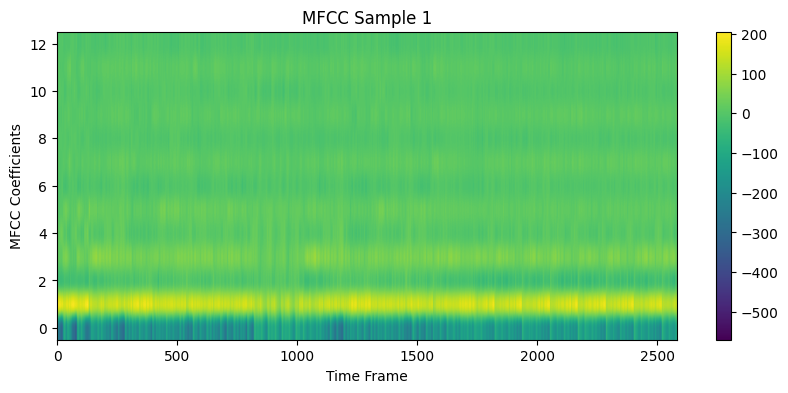

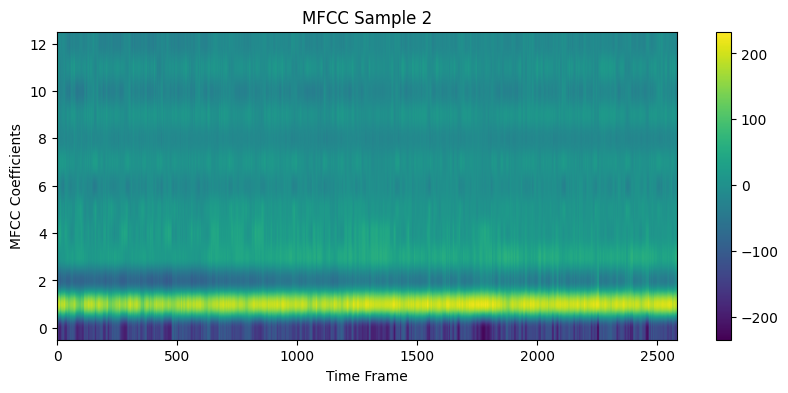

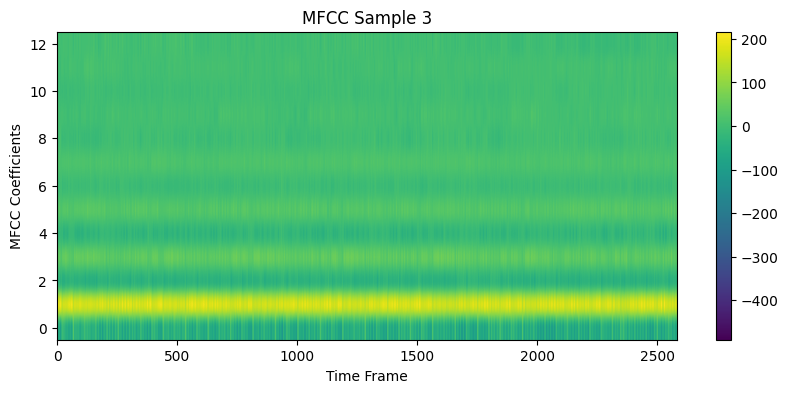

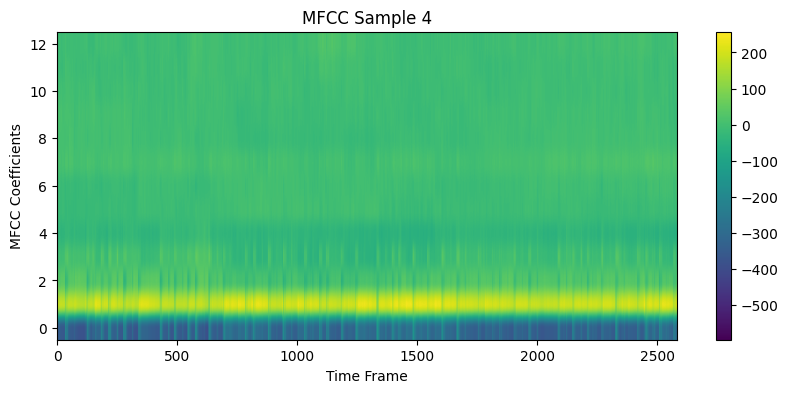

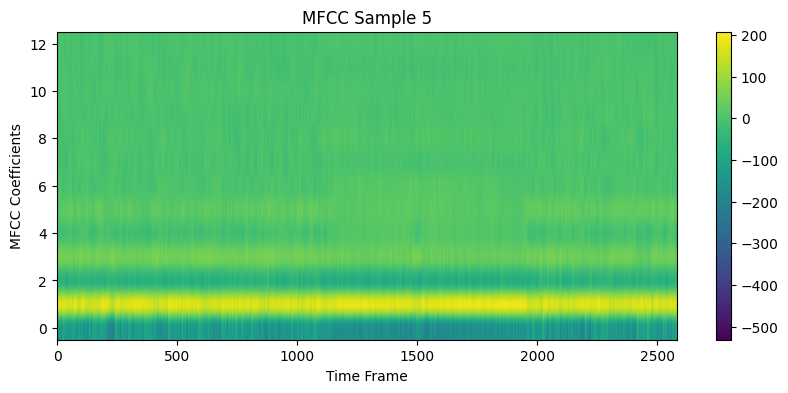

In [5]:
# Function to pad or truncate MFCC features to a fixed length
def process_mfcc_features(mfcc_features, fixed_length=None):
    """
    Process MFCC features to ensure they all have the same length.

    Parameters:
        mfcc_features (np.ndarray): Original MFCC features
        fixed_length (int): Length to pad or truncate to. If None, use the shortest length

    Returns:
        np.ndarray: Processed MFCC features with uniform length
    """
    # Determine the target length (shortest or user-specified)
    if fixed_length is None:
        fixed_length = min(len(mfcc) for mfcc in mfcc_features)

    processed_features = []
    for mfcc in mfcc_features:
        if len(mfcc[0]) > fixed_length:  # Truncate if too long
            processed_features.append(mfcc[:, :fixed_length])
        else:  # Pad if too short
            padding = fixed_length - len(mfcc[0])
            processed_features.append(np.pad(mfcc, ((0, 0), (0, padding)), mode='constant'))

    return np.array(processed_features)

# Updated function to explore MFCC features
def explore_mfcc_features(data_loader, num_samples=5, fixed_length=None):
    """
    Extract and explore MFCC features from the dataset.

    Parameters:
        data_loader (ModelDataLoader): The data loader instance
        num_samples (int): Number of MFCC feature samples to explore
        fixed_length (int): Fixed length to pad or truncate MFCC features

    Returns:
        np.ndarray: A subset of processed MFCC features
    """
    # Load the MFCC features
    mfcc_features = data_loader.get_mfcc()

    # Process MFCC features to ensure uniform shape
    processed_features = process_mfcc_features(mfcc_features, fixed_length)

    # Ensure we are not selecting more samples than available
    num_samples = min(num_samples, processed_features.shape[0])

    # Randomly select a subset of MFCC features
    subset_indices = np.random.choice(processed_features.shape[0], size=num_samples, replace=False)
    subset_mfcc = processed_features[subset_indices]

    # Display the shape and basic statistics of the subset
    print(f"Processed MFCC Features Shape: {processed_features.shape}")
    print(f"Subset Shape: {subset_mfcc.shape}")
    print("\nDescriptive Statistics for Subset:")
    print(f"Mean: {np.mean(subset_mfcc, axis=(0, 2))}")
    print(f"Standard Deviation: {np.std(subset_mfcc, axis=(0, 2))}")

    # Plot the MFCC features for the first few samples
    for i, mfcc in enumerate(subset_mfcc):
        plt.figure(figsize=(10, 4))
        plt.imshow(mfcc, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"MFCC Sample {i + 1}")
        plt.colorbar()
        plt.xlabel("Time Frame")
        plt.ylabel("MFCC Coefficients")
        plt.show()

    return subset_mfcc

# Call the updated function to explore MFCC features
mfcc_subset = explore_mfcc_features(model_data_loader, fixed_length=2582)

Genre Distribution:


,label,Count,Proportion (%)
0,rock,7903,31.767023
1,experimental,5172,20.789453
2,electronic,4298,17.276308
3,hiphop,1479,5.945012
4,folk,1332,5.354128
5,pop,1098,4.413538
6,classical,886,3.561380
7,international,777,3.123241
8,instrumental,547,2.198730
9,jazz,416,1.672160


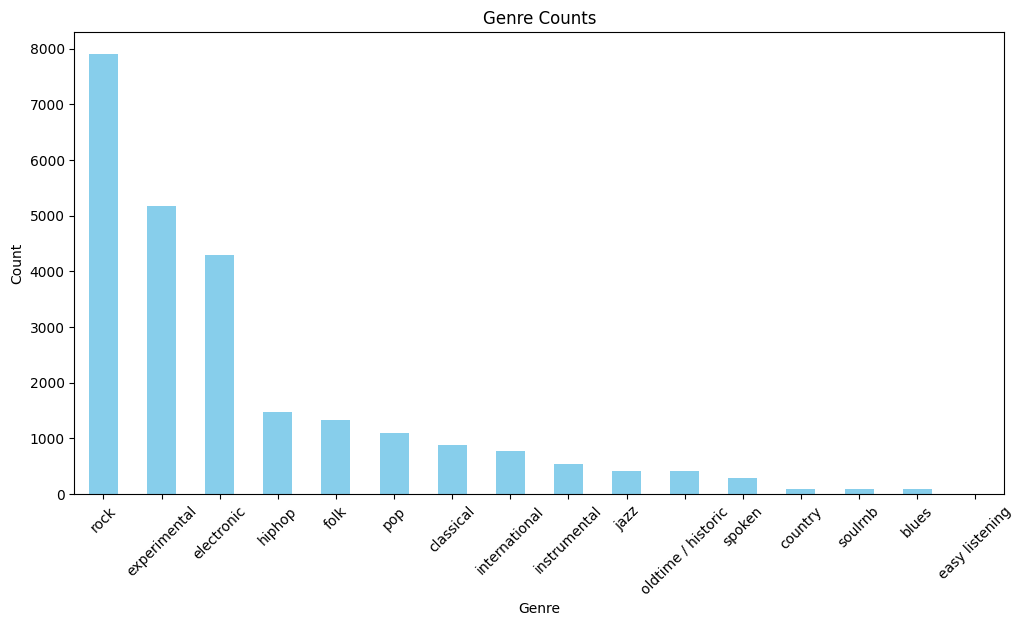

Suggested genres with at least 20 samples: ['rock', 'experimental', 'electronic', 'hiphop', 'folk', 'pop', 'classical', 'international', 'instrumental', 'jazz', 'oldtime / historic', 'spoken', 'country', 'soulrnb', 'blues']


In [6]:
# Function to analyze genre counts and balance dataset
def analyze_genre_distribution(df, label_column='label', threshold=50):
    """
    Analyze genre distribution and suggest genres for balanced classification.

    Parameters:
        df (pd.DataFrame): The DataFrame containing genre labels.
        label_column (str): The column name for genre labels.
        threshold (int): Minimum count threshold for including genres.

    Returns:
        pd.DataFrame: Genre counts and proportions.
    """
    # Count occurrences of each genre
    genre_counts = df[label_column].value_counts()

    # Calculate proportions
    genre_proportions = (genre_counts / genre_counts.sum()) * 100

    # Combine counts and proportions into a single DataFrame
    genre_summary = pd.DataFrame({
        'Count': genre_counts,
        'Proportion (%)': genre_proportions
    }).reset_index()
    genre_summary.rename(columns={'index': 'Genre'}, inplace=True)

    # Display genre distribution
    print("Genre Distribution:")
    display(genre_summary)

    # Plot genre counts
    plt.figure(figsize=(12, 6))
    genre_counts.plot(kind='bar', color='skyblue')
    plt.title('Genre Counts')
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    # Suggest genres to include based on threshold
    included_genres = genre_counts[genre_counts >= threshold].index.tolist()
    print(f"Suggested genres with at least {threshold} samples: {included_genres}")

    return genre_summary, included_genres

# Analyze genre distribution
genre_summary, included_genres = analyze_genre_distribution(model_data_loader.df, label_column='label', threshold=20)

In [7]:
# Analyze genre counts
genre_counts = model_data_loader.df['label'].value_counts()
print("Genre Counts:\n", genre_counts)

# Select genres with at least 1000 samples
selected_genres = genre_counts[genre_counts >= 1000].index.tolist()
print("\nSelected Genres:", selected_genres)

Genre Counts:
 label
rock                  7903
experimental          5172
electronic            4298
hiphop                1479
folk                  1332
pop                   1098
classical              886
international          777
instrumental           547
jazz                   416
oldtime / historic     408
spoken                 288
country                 92
soulrnb                 91
blues                   83
easy listening           8
Name: count, dtype: int64

Selected Genres: ['rock', 'experimental', 'electronic', 'hiphop', 'folk', 'pop']


## SMOTE


In [9]:
# Reload filtered_df from the original dataset
filtered_df = model_data_loader.df.copy()

# Ensure the features column doesn't have any None values
filtered_df = filtered_df[filtered_df['features'].notnull()]

# Include only relevant genres (ensure 'classical' is included)
selected_genres = ['rock', 'experimental', 'electronic', 'hiphop', 'pop', 'folk', 'classical']

# Filter the DataFrame for the selected genres
filtered_df = filtered_df[filtered_df['label'].isin(selected_genres)].copy()

# Preprocess features to ensure consistent shape
max_length = max(filtered_df['features'].apply(lambda x: len(x)))

# Pad or truncate features
def pad_or_truncate(array, max_length):
    if len(array) < max_length:
        # Pad with zeros
        return np.pad(array, (0, max_length - len(array)), mode='constant')
    else:
        # Truncate to max_length
        return array[:max_length]

# Apply padding/truncating to all features
filtered_df['features_padded'] = filtered_df['features'].apply(lambda x: pad_or_truncate(x, max_length))

# Convert to 2D NumPy array
X = np.array(filtered_df['features_padded'].tolist())

print(f"Shape of X after padding/truncating: {X.shape}")

# Extract and encode labels
y = filtered_df['label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Verify the balanced class distribution
print("Class distribution after SMOTE:")
unique, counts = np.unique(y_resampled, return_counts=True)
for label, count in zip(label_encoder.inverse_transform(unique), counts):
    print(f"{label}: {count}")

# Add a channel dimension for CNN input
X_resampled = X_resampled[..., np.newaxis]

print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {y_resampled.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


Shape of X after padding/truncating: (21717, 15)
Class distribution after SMOTE:
classical: 7855
electronic: 7855
experimental: 7855
folk: 7855
hiphop: 7855
pop: 7855
rock: 7855
Shape of X_resampled: (54985, 15, 1)
Shape of y_resampled: (54985,)


## Models

### Function for Visualizations

In [11]:
def plot_model_performance(history, y_test, y_pred_classes, label_encoder):
    """
    Function to plot training and validation accuracy/loss and the confusion matrix.

    Parameters:
        history (History): Training history returned by model.fit.
        y_test (array): True labels of the test set.
        y_pred_classes (array): Predicted classes from the model.
        label_encoder (LabelEncoder): Encoder to decode class labels for plotting.
    """

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

### CNN

Epoch 1/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.2418 - loss: 1.9154 - val_accuracy: 0.3506 - val_loss: 1.6414 - learning_rate: 0.0010
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3273 - loss: 1.6823 - val_accuracy: 0.3823 - val_loss: 1.5612 - learning_rate: 0.0010
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3460 - loss: 1.6478 - val_accuracy: 0.3801 - val_loss: 1.5568 - learning_rate: 0.0010
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3596 - loss: 1.6298 - val_accuracy: 0.3706 - val_loss: 1.5592 - learning_rate: 0.0010
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3641 - loss: 1.6200 - val_accuracy: 0.3926 - val_loss: 1.5327 - learning_rate: 0.0010
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.3714 - loss: 1.6019 - val_accuracy: 0.4024 - val_loss: 1.5203 - learning_rate: 0.0010
Epoch 7/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.37

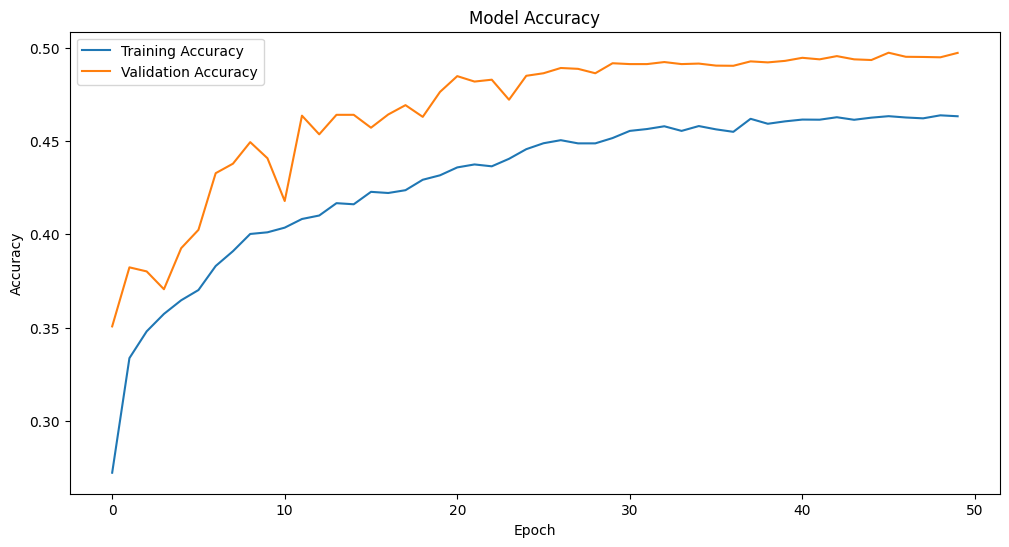

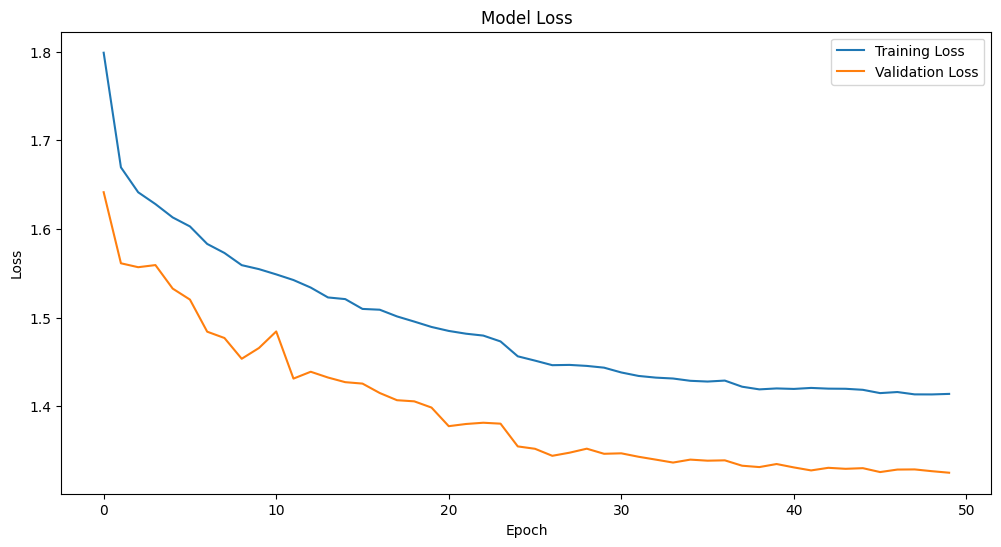


Classification Report:
              precision    recall  f1-score   support

   classical       0.74      0.92      0.82      1571
  electronic       0.48      0.26      0.34      1571
experimental       0.44      0.35      0.39      1571
        folk       0.54      0.50      0.52      1571
      hiphop       0.45      0.71      0.55      1571
         pop       0.33      0.16      0.22      1571
        rock       0.40      0.58      0.47      1571

    accuracy                           0.50     10997
   macro avg       0.48      0.50      0.47     10997
weighted avg       0.48      0.50      0.47     10997



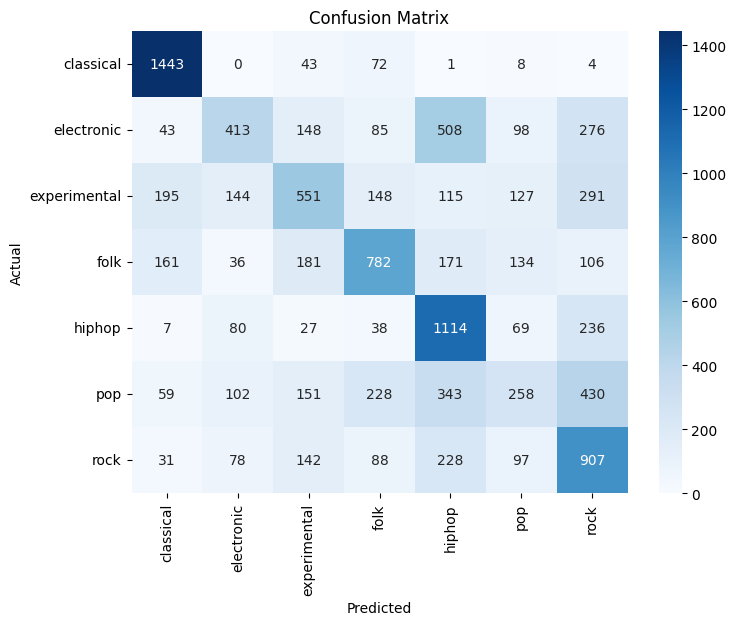

In [12]:
# Define the CNN model with adjusted architecture
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=2, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=1),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(np.unique(y_resampled)), activation='softmax')  # Adjust for number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Call the visualization function
plot_model_performance(history, y_test, y_pred_classes, label_encoder)


### LSTM

Epoch 1/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 68s 41ms/step - accuracy: 0.2491 - loss: 1.8567 - val_accuracy: 0.2492 - val_loss: 1.8091 - learning_rate: 0.0010
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - accuracy: 0.3023 - loss: 1.7359 - val_accuracy: 0.3445 - val_loss: 1.8817 - learning_rate: 0.0010
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 65s 47ms/step - accuracy: 0.3242 - loss: 1.6967 - val_accuracy: 0.3680 - val_loss: 2.0942 - learning_rate: 0.0010
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3430 - loss: 1.6686
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 76s 43ms/step - accuracy: 0.3430 - loss: 1.6686 - val_accuracy: 0.3111 - val_loss: 1.9933 - learning_rate: 0.0010
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - accuracy: 0.3534 - loss: 1.6369 - val_accuracy: 0.3838 - val_loss: 1.8055 - learning_rate: 5.0000e-04
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 86s 44ms/step - accu

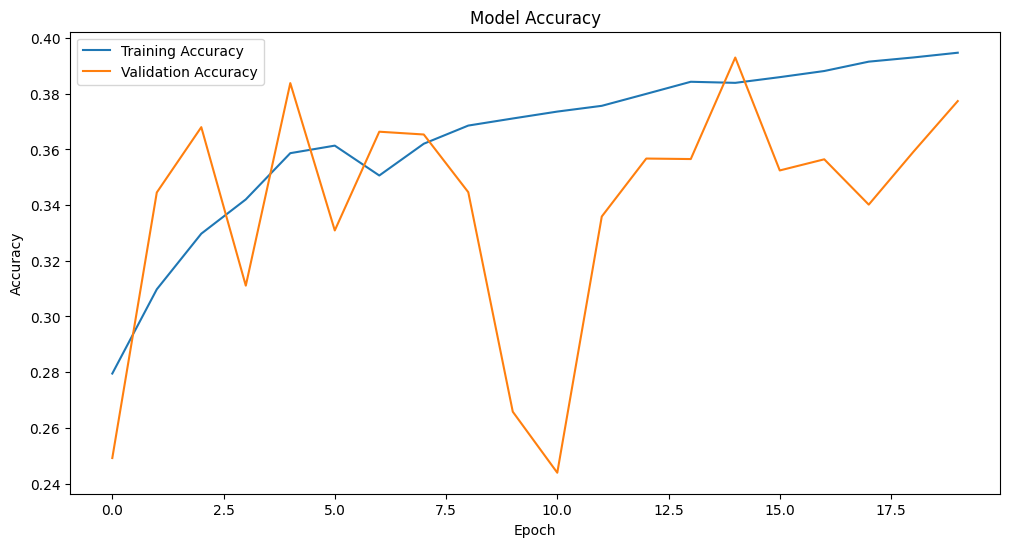

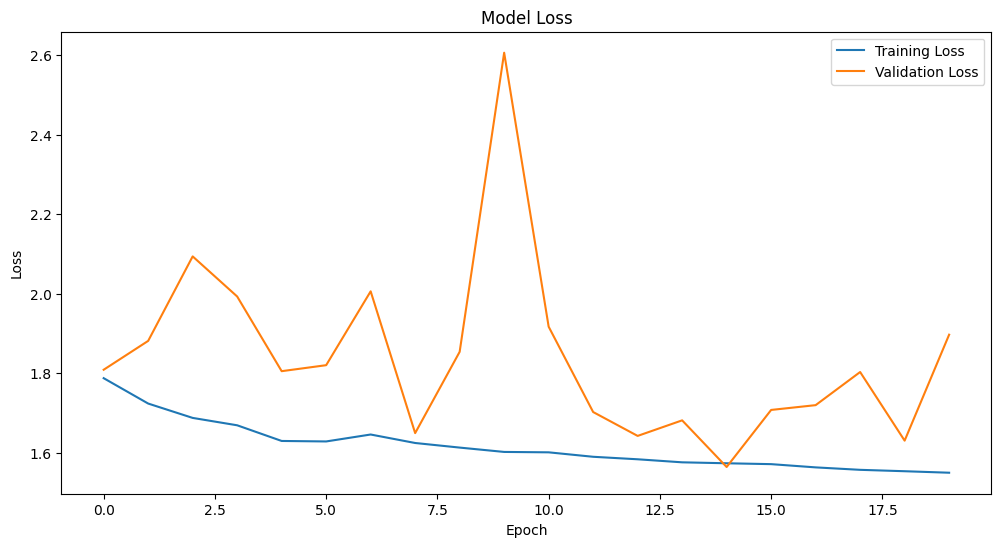


Classification Report:
              precision    recall  f1-score   support

   classical       0.80      0.74      0.77      1571
  electronic       0.48      0.21      0.29      1571
experimental       0.37      0.18      0.24      1571
        folk       0.36      0.55      0.44      1571
      hiphop       0.29      0.66      0.41      1571
         pop       0.21      0.01      0.02      1571
        rock       0.30      0.40      0.35      1571

    accuracy                           0.39     10997
   macro avg       0.40      0.39      0.36     10997
weighted avg       0.40      0.39      0.36     10997



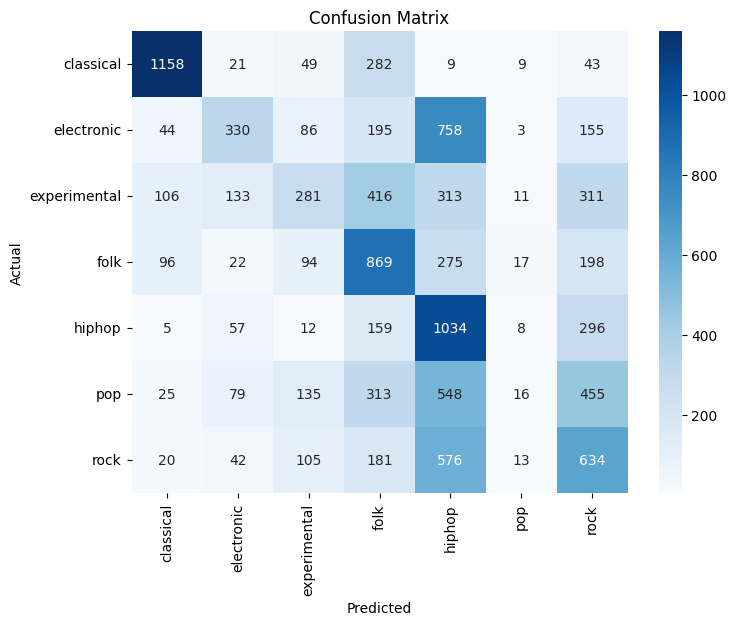

In [14]:
# Define the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(len(np.unique(y_resampled)), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Call the visualization function
plot_model_performance(history, y_test, y_pred_classes, label_encoder)


### CNN + LSTM

Epoch 1/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 96s 39ms/step - accuracy: 0.2854 - loss: 1.7546 - val_accuracy: 0.3798 - val_loss: 1.6232 - learning_rate: 0.0010
Epoch 2/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.3598 - loss: 1.6204 - val_accuracy: 0.4132 - val_loss: 1.5368 - learning_rate: 0.0010
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 53s 38ms/step - accuracy: 0.3731 - loss: 1.5882 - val_accuracy: 0.3651 - val_loss: 1.6358 - learning_rate: 0.0010
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.3850 - loss: 1.5770 - val_accuracy: 0.4077 - val_loss: 1.5396 - learning_rate: 0.0010
Epoch 5/50
1374/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3926 - loss: 1.5540
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.3926 - loss: 1.5540 - val_accuracy: 0.3775 - val_loss: 1.5457 - learning_rate: 5.0000e-04
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accu

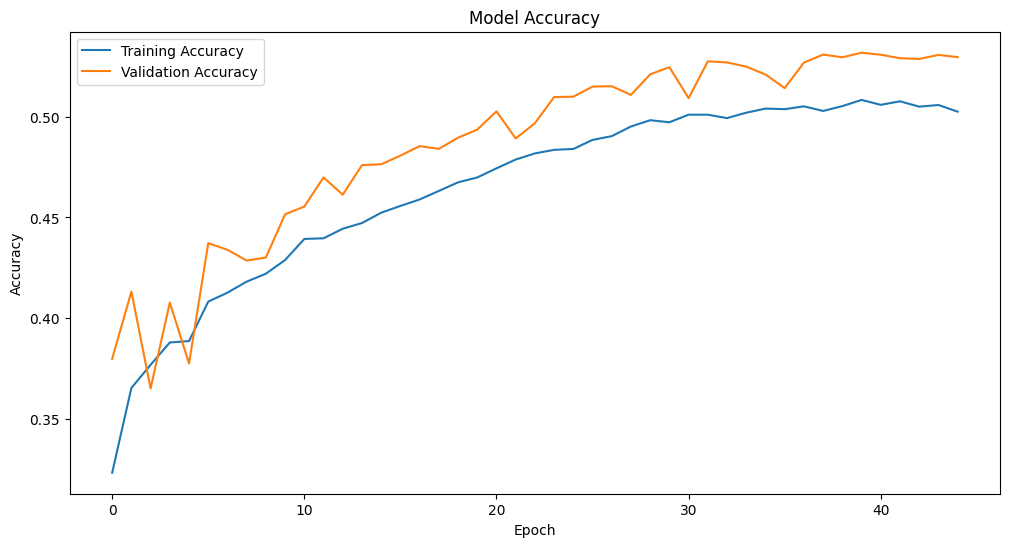

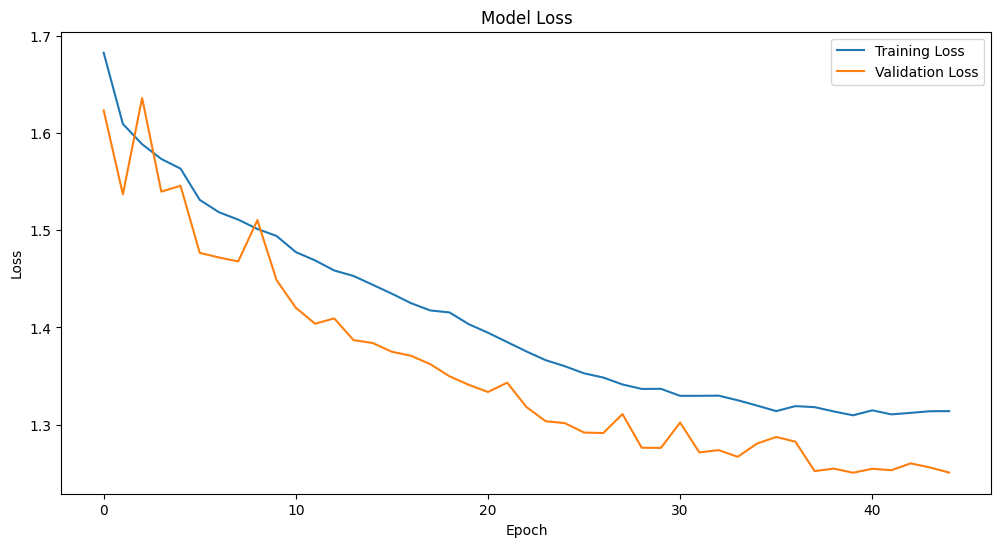


Classification Report:
              precision    recall  f1-score   support

   classical       0.82      0.91      0.86      1571
  electronic       0.47      0.32      0.38      1571
experimental       0.45      0.36      0.40      1571
        folk       0.55      0.62      0.58      1571
      hiphop       0.51      0.74      0.61      1571
         pop       0.33      0.23      0.27      1571
        rock       0.48      0.54      0.51      1571

    accuracy                           0.53     10997
   macro avg       0.51      0.53      0.52     10997
weighted avg       0.51      0.53      0.52     10997



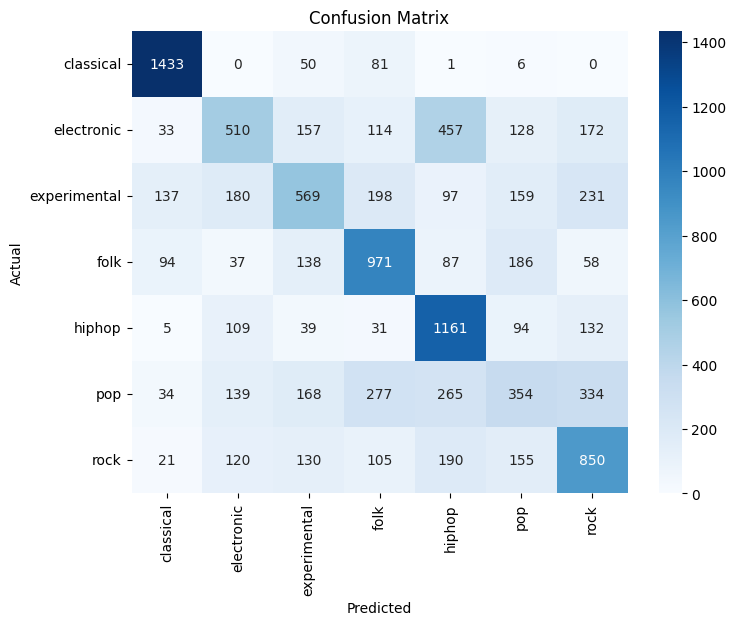

In [17]:
# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  # Reduce learning rate by 10% after every epoch

lr_scheduler = LearningRateScheduler(scheduler)

# Define the fine-tuned CNN+LSTM model
model = Sequential([
    # CNN Layers
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Dropout(0.3),

    # LSTM Layers
    LSTM(256, return_sequences=True, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    LSTM(128, return_sequences=False, activation='relu'),
    Dropout(0.4),

    # Fully Connected Layers
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(len(np.unique(y_resampled)), activation='softmax')  # Adjust for number of classes
])

# Compile the model with a custom learning rate
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the fine-tuned model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        lr_scheduler  # Learning rate scheduler
    ]
)

# Evaluate the fine-tuned model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_classes = np.argmax(model.predict(X_test), axis=1)

# Call the visualization function
plot_model_performance(history, y_test, y_pred_classes, label_encoder)


## **Report: Comparing CNN, LSTM, and CNN+LSTM Models**

---

### **Overview of Model Results**

| Model         | Test Accuracy | Test Loss |
|---------------|---------------|-----------|
| **CNN**       | 49.72%        | 1.3250    |
| **LSTM**      | 39.30%        | 1.5645    |
| **CNN+LSTM**  | **53.18%**    | **1.2506** |

---

### **Key Observations**

#### **1. Performance Comparison**
- The **CNN+LSTM model** outperforms both the CNN and LSTM models in terms of accuracy and test loss.
- The **LSTM model** performs the worst, likely struggling to extract spatial (local) patterns from MFCCs, which are better handled by CNN layers.
- The **CNN model** achieves reasonable performance but lacks the sequential processing capability that LSTM layers provide.

---

#### **2. Genre Prediction Challenges**
##### **Hard-to-Predict Genres**
- **Electronic** and **Pop** have consistently poor performance across all models:
  - **Electronic** is often misclassified as **Experimental** or **Rock**, possibly due to shared characteristics like diverse instrumentation or timbre overlap.
  - **Pop** is confused with multiple genres like **Electronic** and **Rock**, likely due to its broad stylistic range.
- The confusion matrices show these patterns clearly, indicating feature overlap and insufficient separation in the feature space.

##### **Easier-to-Predict Genres**
- **Classical** and **Hip-Hop** are the easiest to classify:
  - **Classical** has distinct audio features like lower tempo, higher tonal stability, and structured harmonic content.
  - **Hip-Hop** stands out due to rhythm-driven features like strong beats and higher zero-crossing rates.

---

#### **3. Learning Rate**
- The oscillations (wiggles) in the training and validation accuracy/loss charts for the **LSTM** and **CNN+LSTM** models are due to the **learning rate adjustments**:
  - The **LearningRateScheduler** reduces the learning rate by 10% after every epoch (post-epoch 10).
  - These adjustments allow the model to refine its learning gradually, but they also create temporary instability as the optimizer recalibrates to the new learning rate.

---

### **Conclusion**
- The **CNN+LSTM model** is currently the best performer, combining the spatial extraction of CNNs and sequential processing of LSTMs.
- However, challenges remain with distinguishing overlapping genres like **Electronic** and **Pop**, requiring additional feature engineering or advanced architectures.
